# Label and Track Voids
Our first step in gathering the 3D positions of voids is to identify their location in each image of the tilt series, then track their movement across each image.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.drift import compute_drift_from_tracks
from rtdefects.segmentation.pytorch import PyTorchSemanticSegmenter
from rtdefects.analysis import analyze_defects, convert_to_per_particle, compile_void_tracks
from rtdefects.io import load_file
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import trackpy as tp
import pandas as pd
import numpy as np

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TODO: Convert from pixels to nm

## Load the Images
Get the names of positions of each image

In [2]:
images = []
for image in Path('images/').glob('tilt*.png'):
    images.append({
        'path': str(image),
        'frame': int(image.name[4:-4])
    })
images = pd.DataFrame(images).sort_values('frame')
print(f'Loaded {len(images)} from tilt series')

Loaded 10 from tilt series


## Segment them
Use the latest model from the void segmentation approach. The procedure for analyzing a single image is to:

1. Load image from disk into a standard representation: grayscale represented as a floating point between 0-1
2. Convert image into the form needed by a particular model
3. Run segmentation to get the pixels for each void
4. Run analysis to get a summary of the positions, sizes, etc for each void

In [3]:
segmenter = PyTorchSemanticSegmenter()
print(f'Loaded the {segmenter.model_path.name} segmentation model.')

Loaded the small_voids_031023.pth segmentation model.


In [4]:
results = []
for path in tqdm(images['path']):
    img = load_file(path)
    std_img = segmenter.transform_standard_image(img)
    labeled_img = segmenter.perform_segmentation(std_img)
    result = analyze_defects(labeled_img)
    result['labeled_img'] = labeled_img
    results.append(result)
results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]


In [5]:
images = pd.concat([images, results], axis=1)

We now have the locations and sizes of voids for each frame

## Run the Particle Tracking
We use [trackpy](https://soft-matter.github.io/trackpy/dev/), which expects each row in the dataframe to be a particle rather than a frame

In [6]:
particles = pd.concat(list(convert_to_per_particle(images))).query('not touches_side')
particles.head(5)

,x,y,local_id,frame,radius,touches_side
6,705.981818,13.854545,6,1,4.184142,False
7,729.123077,13.676923,7,1,4.548642,False
8,135.911111,16.144444,8,1,5.352372,False
9,635.136000,20.272000,9,1,8.920621,False
10,26.051546,22.752577,10,1,5.556623,False


Run the tracking, using a wide search range for the drift of a single void and no memory for voids being lost between frames.

Rationale: We are only looking for a few easy-to-track particles to use when determining the tilt axis

In [7]:
initial_tracks = tp.link_df(particles, search_range=16, memory=1)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles out of {len(particles)} labelled.')

Frame 9: 550 trajectories present.
Found a total of 2244 unique particles out of 4417 labelled.


The output is the void in each frame assigned with a global ID, "particle"

In [8]:
initial_tracks

,x,y,local_id,frame,radius,touches_side,particle
197,26.655172,586.534483,197,0,4.296740,False,0
252,574.044715,770.304878,252,0,12.514330,False,1
251,519.746795,764.150641,251,0,9.965575,False,2
250,80.303571,754.232143,250,0,4.222008,False,3
249,55.137255,753.568627,249,0,4.029120,False,4
...,...,...,...,...,...,...,...
375,615.553684,693.115789,375,9,12.296227,False,644
374,1006.424658,684.698630,374,9,4.820438,False,1712
373,80.721154,685.875000,373,9,5.753627,False,2243
379,876.961538,691.641026,379,9,4.982787,False,1711


We'll next produce a summary where we group the same particule into each row

In [9]:
initial_void_tracks = compile_void_tracks(initial_tracks)
initial_void_tracks.sort_values('total_frames', ascending=False).head()

,start_frame,end_frame,total_frames,inferred_frames,positions,touches_side,local_id,radii,max_radius,min_radius,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,growth_rate
340,0,9,10,2,"[[340.8484848484849, 409.530303030303], [345.8...","[False, False, False, False, False, False, Fal...","[132, None, 162, 148, 158, 204, 229, 194, None...","[4.583497844237541, 9.161206005960764, 13.7389...",13.738914,4.583498,"[0.0, 5.323026767470256, 10.646053534940512, 7...",24.837646,2.483765,"[0.0, 5.323026767470256, 10.646053534940512, 2...",68.163608,6.816361,0.169382
143,0,9,10,3,"[[936.3693181818181, 874.0823863636364], [934....","[False, False, False, False, False, False, Fal...","[299, 354, None, 344, 362, 430, None, 411, Non...","[10.585134856802455, 10.013371767186818, 8.791...",10.585135,5.641896,"[0.0, 2.489969481129466, 5.1023129482621625, 7...",15.988860,1.598886,"[0.0, 2.489969481129466, 5.265541536230169, 8....",49.866610,4.986661,-0.555214
202,0,9,10,3,"[[349.82666666666665, 253.84], [354.9039875389...","[False, False, False, False, False, False, Fal...","[89, None, 104, None, 93, 126, None, 119, 105,...","[4.886025119029199, 5.361023775294347, 5.83602...",6.432751,4.406462,"[0.0, 7.351990432888108, 14.703980865776234, 1...",25.791179,2.579118,"[0.0, 7.351990432888108, 14.703980865776234, 1...",57.588364,5.758836,0.054042
26,0,9,10,3,"[[964.6125, 804.79375], [964.6750840807174, 80...","[False, False, False, False, False, False, Fal...","[273, None, 313, 318, None, 391, 425, 366, Non...","[7.136496464611085, 9.525726919593703, 11.9149...",13.351162,5.170883,"[0.0, 0.6610549430593472, 1.3221098861185918, ...",31.390141,3.139014,"[0.0, 0.6610549430593472, 1.322109886118592, 8...",49.865015,4.986502,0.119178
51,0,9,10,2,"[[715.6424242424242, 602.9666666666667], [714....","[False, False, False, False, False, False, Fal...","[200, None, 222, None, 229, 281, 315, 268, 245...","[10.249012754438885, 11.800087555343989, 13.35...",13.634257,4.333622,"[0.0, 5.807213477186738, 11.6144269543735, 13....",21.119718,2.111972,"[0.0, 5.807213477186738, 11.6144269543735, 15....",67.622976,6.762298,-1.178393


## Compute Drift and Re-Run Tracking
The tracks give us some idea of drift, which we can use to improve the identification of other tracks

Compute drift then subtract it from the particle positions

In [10]:
drift = compute_drift_from_tracks(initial_tracks)
drift

array([[ 0.        ,  0.        ],
       [ 0.69080252,  0.10161348],
       [ 0.24227679, -0.05787819],
       [ 0.50767126, -2.32532639],
       [-4.76249566,  4.21682211],
       [ 3.83870996,  9.49588731],
       [ 4.92599871,  9.06409521],
       [ 2.3048236 ,  8.0137429 ],
       [ 2.76466006,  8.84924926],
       [ 2.97610038,  5.94037321]])

In [11]:
images['positions-no-drift'] = images.apply(lambda x: np.subtract(x['positions'], drift[x['frame'] - 1, :]), axis=1)

Redo the tracking with the 

In [12]:
particles = pd.concat(list(convert_to_per_particle(images, position_col='positions-no-drift'))).query('not touches_side')
tracks = tp.link_df(particles, search_range=16, memory=1)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles out of {len(particles)} labelled.')

Frame 9: 550 trajectories present.
Found a total of 2244 unique particles out of 4417 labelled.


In [13]:
void_tracks = compile_void_tracks(tracks)
void_tracks.sort_values('total_frames', ascending=False).head()

,start_frame,end_frame,total_frames,inferred_frames,positions,touches_side,local_id,radii,max_radius,min_radius,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,growth_rate
84,0,9,10,2,"[[924.4424223401345, 630.4622205804176], [922....","[False, False, False, False, False, False, Fal...","[213, 239, 247, None, 252, 304, 338, 284, None...","[4.259537945889915, 13.957279475043833, 5.8086...",13.957279,4.259538,"[0.0, 1.9500745649647626, 7.513096711181075, 9...",22.162873,2.216287,"[0.0, 1.9500745649647626, 11.258680965615211, ...",48.609589,4.860959,0.136197
254,0,9,10,2,"[[462.59921137153657, 87.3266610934649], [464....","[False, False, False, False, False, False, Fal...","[35, None, 41, 29, 34, 53, 50, None, 26, 45]","[8.703892974511014, 10.077845392836224, 11.451...",13.134838,4.184142,"[0.0, 2.6256147586666496, 5.2512295173333055, ...",15.325503,1.532550,"[0.0, 2.6256147586666496, 5.2512295173333055, ...",61.478479,6.147848,0.010657
226,0,9,10,3,"[[364.5296403852473, 48.50582960297397], [363....","[False, False, False, False, False, False, Fal...","[17, 25, None, 23, None, 25, None, 23, 17, 30]","[14.549091872423544, 7.1809610472257885, 6.191...",14.549092,5.046265,"[0.0, 13.58624041533986, 12.712034612094063, 1...",15.242208,1.524221,"[0.0, 13.58624041533986, 18.936362017655064, 2...",70.522500,7.052250,-0.191011
120,0,9,10,3,"[[731.5740012875029, 985.4359047909439], [730....","[False, False, False, False, False, False, Fal...","[359, None, 393, 386, None, 497, None, 478, 44...","[4.068428945128219, 5.299697773265093, 6.53096...",6.530967,4.068429,"[0.0, 4.242740835597505, 8.485481671194934, 8....",12.446318,1.244632,"[0.0, 4.242740835597505, 8.485481671194933, 16...",60.765324,6.076532,0.329117
48,0,9,10,2,"[[989.1088850084332, 606.6161373490835], [980....","[False, False, False, False, False, False, Fal...","[204, 237, 234, 226, None, 303, 325, 270, None...","[7.399277020331919, 6.793742230659745, 5.91727...",7.399277,4.618091,"[0.0, 12.979177075324426, 21.471769322317915, ...",33.538523,3.353852,"[0.0, 12.979177075324426, 27.602536197387856, ...",86.467650,8.646765,-0.195260


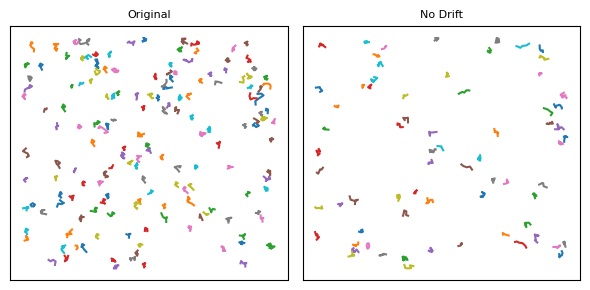

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

for ax, t, l in zip(axs, [initial_void_tracks, void_tracks], ['Original', 'No Drift']):
    ax.set_yticks(ax.set_xticks([]))
    ax.set_title(l, fontsize=8)
    for p in t.query('total_frames > 6')['positions']: 
        ax.plot(p[:, 0], p[:, 1])

fig.tight_layout()

We can use this to save an easy summary of where each void is during each frame

## Save for later use
Let's save a few things separately.

First, the data for each frame

In [15]:
results.drop(columns=['labeled_img']).to_json('frame-data.json', orient='records', lines=True)

Then the summary of void tracks, in full detail

In [16]:
void_tracks.to_json('track-data.json', orient='records', lines=True)

Now the CSV of voids that are tracked across many frames coordinates in 2D

In [17]:
tracked_coords = defaultdict(list)
for rid, row in void_tracks.query('total_frames >= 8').iterrows():
    for i, (x, y) in enumerate(row['positions']):
        tracked_coords['id'].append(rid)
        tracked_coords['frame'].append(i + row['start_frame'])
        tracked_coords['x'].append(x)
        tracked_coords['y'].append(y)
    tracked_coords['r'].extend(row['radii'])
tracked_coords = pd.DataFrame(tracked_coords)

In [18]:
tracked_coords.to_csv('void-2d-coordinates.csv', index=False)